## OVERVIEW: 
### The Notebook demonstrates the use of having a Class and a bunch of methods which can help us carryout 
### basic yet standard data science model building processes, right from loading data, preprocessing, parameter optimization, to Model building


### One can use this framework and build on top of the methods and features with ease to extend the functionality of the Class

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error
import sklearn.cross_validation
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import numpy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns 
#Step_1: Splitting the Data into Train and Test Set
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,accuracy_score, classification_report

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class Pipeline:
    "Carry out standard Data Science processes including data preprocessing, model building, "
    "model parameter optimizion, and validating the model"
    
    def __init__(self, data, target=None):
        self.target = target
        self.data = data
        

    def display_data(self, data, describe = True, display_dtype = True):
        "Input: A pandas DataFrame, display data shape, null values, number of duplicated records,"
        "optionally display descriptive statistics of data and info wrt variable dtype"
        
        self.data = data
        display(data.head())
        print('Shape of the Data set:\n', self.data.shape)
        print('\n Total Null Values:\n', self.data.isnull().sum())
        print("\n Total duplicated records:\n", self.data.duplicated().sum())
        if display_dtype:
            print('\n Dtype INFO:\n', self.data.dtypes)
        if describe:
            print("\n Descriptive statistics: \n", self.data.describe())
        
        
    def plot(self,  data, plot_type = 'reg'):
        "Input: Pandas DataFrame, plot pairplot for any number of numerical features"
       
        self.data = data
        sns.pairplot(data, kind = plot_type)
        
        
    def change_col_dtypes(self,data, dtype_col_dict = {}):
        "Input: A pandas DataFrame and a dictonary consisting of col names and dtype they need to be converted into"
        "Return: pandas Dataframe with columns converted to the specified dtypes"
        
        self.data = data
        self.data = self.data.astype(dtype_col_dict)
        
        return self.data
        
        
    def filtering_outliers_using_n_standard_deviation(self, data, num_cols_list = None, n = 2):
        "Input: pandas DataFrame, a list of cols to carryout outlier filtering on, a threshold point in the form of"
        "n standard deviation away from mean,Remove rows that are n std dev away from mean for selected cols"
        "Return: Filtered DataFrame"
        
        self.data = data
        for col in self.data.columns:
            if col in num_cols_list:
                mean = self.data[col].mean()
                std_dev = self.data[col].std()
                upper = mean + abs(n) * std_dev
                lower = mean - abs(n) * std_dev
                bad_idx_list = []
                bad_idx = self.data[(self.data[col] >= upper) | (self.data[col] <= lower)].index
                bad_idx_list.append(bad_idx)
                flat_list = [item for sublist in bad_idx_list for item in sublist]
                clean_data = data.loc[~self.data.index.isin(bad_idx)]

        return clean_data
    
        
    def missing_value_info_and_treatment(self, data, threshold_pct = 100):
        "Input: pandas DataFrame, threshold_pct refers to a threshold perecentage(1-100) of allowing missing values" 
        "to exist in column else drop the column"
        "Return: Filtered data/Original DataFrame"
        
        self.data = data
        print('Inital shape of data', self.data.shape)
        total = self.data.isnull().sum().sort_values(ascending=False)
        percent = (self.data.isnull().sum()/self.data.isnull().count()*100).sort_values(ascending=False)
        dtype = self.data.dtypes
        missing_data = pd.concat([total, percent, dtype], axis=1, keys=['Number of Missing Values', 
                                                                        'Missing Values Percentage', "dtype"])
        missing_data = missing_data.sort_values('Missing Values Percentage',ascending= False)
        display(missing_data)
        good_cols = missing_data[missing_data['Missing Values Percentage'] < threshold_pct].index.tolist() 
        self.data = self.data[good_cols]
        print('Duplicates being Dropped...')
        print('Number of duplicates in the dataset ', self.data.duplicated().sum())
        self.data.drop_duplicates(inplace = True)
        print('shape of data after the treatment', self.data.shape)

        return self.data
        
    
    def fillna_for_numerical_and_categorical_variables(self, data, num_cols = None, cat_cols = None, drop_cols = None):
        "Input: pandas DataFrame,Impute missing value in numerical columns by mean and categorical columns by the mode"
        "for the selected list of num_cols and cat_cols, drop columns by selecting cols as a list using drop_cols"
        "Return: pandas DataFrame with imputation on missing values"
        
        self.data = data
        self.data.drop(columns = drop_cols, inplace = True)
        
        for num_col in num_cols:
            self.data[num_col].fillna(self.data[num_col].mean(), inplace = True)
        
        for cat_col in cat_cols:
            self.data[cat_col].fillna(self.data[cat_col].mode()[0], inplace = True)
        return self.data
    
    
    def encoding_categorical_cols(self, data, encode_cols_list = None, one_hot_encode_list = None):
        "Input: pandas DataFrame, list of columns to LabelEncode and OnehotEncode"
        "Return: Encode columns inplace in the Input DataFrame"
        
        self.data = data
        for col in encode_cols_list:
            label_encode = LabelEncoder()
            self.data[col] = label_encode.fit_transform(self.data[col].astype(str))
            
        for col in one_hot_encode_list:
            self.data[col] = pd.get_dummies(self.data[col])
            
        return self.data
    
    
    def scaling_numerical_features(self, data, scale_cols_list):
        "Input: pandas DataFrame, list of cols to be scaled (standard scaler) using scale_cols_list"
        "Return: pandas DataFrame with scaling done inplace for selected cols"
        
        self.data = data
        scaled_features = self.data.copy()
        features = scaled_features[scale_cols_list]
        scaler = StandardScaler()
        scaled_num_cols = scaler.fit_transform(features.values)
        self.data[scale_cols_list] = scaled_num_cols
        
        return self.data
    
    
    def feature_importance(self, data, thresold_importance = 0):
        "Input: pandas DataFrame, threshold importance(0-1) the min % of variance below which cols will be dropped"
        "Return: Filtered DataFrame"
        
        self.data = data
        model = RandomForestClassifier(100, oob_score = True, random_state=99)
        features = self.data.drop(columns=[self.target])
        labels = self.data[self.target]
        model.fit(features,labels)
        feature_importance = pd.Series(model.feature_importances_, index = features.columns).sort_values()
        feature_importance.plot( kind = 'barh', figsize = (7,6));
        df = pd.DataFrame(feature_importance, columns= ['importance'])
        good_cols = df[df['importance'] > thresold_importance].index.tolist()
        good_cols.append(self.target)
        return self.data[good_cols]

    
    def kfold_cross_val_with_param_grid(self,data, k = 5, model = None, scoring = None, parameter_grid = []):
        "Input: pandas DataFrame, k to specify number of folds (5 by default), estimator we wish to fit, appropriate"
        "scoring parameter for the estimator, parameter grid"
        "Displays baseline accuracy of model and best parameter values"
        
        self.model = model
        self.data = data
        Y = self.data[self.target]    
        X = self.data.drop(columns = [self.target])
        clf = (getattr(sklearn.ensemble, model))()
        kfold = KFold(n_splits= k, random_state=99)
        results = cross_val_score(clf, X, Y, cv=kfold, scoring=scoring, verbose=3)
        print("Baseline Model accuracy: %.2f (%.2f) Accuracy" % (results.mean(), results.std()))
        
        # Create a classifier object with the classifier and parameter candidates
        clf = GridSearchCV(estimator = clf, param_grid=parameter_grid,scoring=scoring, n_jobs=-1, cv = k)

        # Train the classifier on data's feature and target 
        clf.fit(X, Y)
        
        print('Best params:',clf.best_estimator_.n_estimators)
        print('Best max_depth:',clf.best_estimator_.max_depth)
        
        
        
    def final_model(self, data, model,best_params,scoring=None, k=5):
        "Input: a pandas DataFrame,best params obtained from grid search,estimator as the model, appropriate scoring"
        "criteria for model. Displays models K-Fold accuracy with best params"
        
        features = self.data.drop(columns=[self.target])
        labels = self.data[self.target]
        clf = (getattr(sklearn.ensemble, model))(**best_params)
        kfold = KFold(n_splits= k, random_state=99)
        results = cross_val_score(clf, features, labels, cv=kfold, scoring=scoring, verbose=5)
        
        print("Model with best params, Results: %.2f (%.2f) Accuracy" % (results.mean(), results.std()))


### Reading the data

In [3]:
data = pd.read_csv('//Users//shrinivas.kallol//Downloads//titanic.csv', delimiter='\t')

#### Lets initialize our class using a variable object_1, we are using the famous titanic data set, a binary classification problem
#### with 1 representing that a passenger onboard Survived, 0 otherwise

In [4]:
object_1 = Pipeline(data, target='Survived') 

### Displaying Data Summary

In [5]:
object_1.display_data(data, display_dtype= True, describe=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Shape of the Data set:
 (156, 12)

 Total Null Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             30
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          125
Embarked         1
dtype: int64

 Total duplicated records:
 0

 Dtype INFO:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

 Descriptive statistics: 
        PassengerId    Survived      Pclass         Age       SibSp  \
count   156.000000  156.000000  156.000000  126.000000  156.000000   
mean     78.500000    0.346154    2.423077   28.141508    0.615385   
std      45.177428    0.477275    0.795459   14.613880    1.056235   
min       1.000000    0.000000    1.000000    0.830000    0

### Changing Dtypes

In [6]:
data_dtyped = object_1.change_col_dtypes(data, dtype_col_dict={'PassengerId':'object','Pclass':'object', 'SibSp': 'object', 'Parch': 'object'})


In [7]:
data_dtyped.dtypes

PassengerId     object
Survived         int64
Pclass          object
Name            object
Sex             object
Age            float64
SibSp           object
Parch           object
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Missing Value Info

In [8]:
data_no_missing = object_1.missing_value_info_and_treatment(data_dtyped, threshold_pct=100)

Inital shape of data (156, 12)


,Number of Missing Values,Missing Values Percentage,dtype
Cabin,125,80.128205,object
Age,30,19.230769,float64
Embarked,1,0.641026,object
Fare,0,0.000000,float64
Name,0,0.000000,object
Parch,0,0.000000,object
PassengerId,0,0.000000,object
Pclass,0,0.000000,object
Sex,0,0.000000,object
SibSp,0,0.000000,object


Duplicates being Dropped...
Number of duplicates in the dataset  0
shape of data after the treatment (156, 12)


### Missing Value Imputation, Fill Nan's for numerical columns using Mean and Categorical columns using Mode

In [9]:
No_missing_vals_df = object_1.fillna_for_numerical_and_categorical_variables(data_no_missing, num_cols = ['Age'], cat_cols=['Embarked'], drop_cols=['Cabin'])

### Plots for Numerical Columns

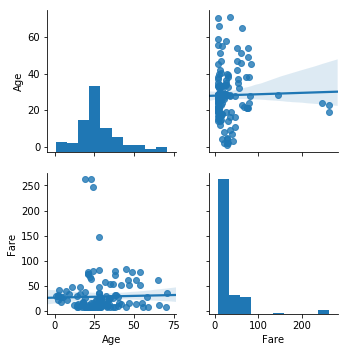

In [10]:
sns.pairplot(No_missing_vals_df[['Age', 'Fare']], kind='reg')

### Encoding categorical columns using LabelEncode and OnehotEncode

In [11]:
encoded_df = object_1.encoding_categorical_cols(No_missing_vals_df,encode_cols_list=['Embarked','Name','Parch','PassengerId','Pclass',
                                                                   'SibSp', 'Survived', 'Ticket'], one_hot_encode_list=['Sex'])

### StandardScaler to scale numerical columns 

In [12]:
scaled_df = object_1.scaling_numerical_features(No_missing_vals_df, scale_cols_list=['Age','Fare'])

,Parch,Embarked,SibSp,Pclass,Fare,Age,PassengerId,Name,Ticket,Sex,Survived
0,0,2,1,2,-0.531122,-0.469480,0,19,103,0,0
1,0,0,1,0,1.099279,0.753620,68,33,124,1,1
2,0,2,0,2,-0.513935,-0.163705,79,59,142,1,1
3,0,2,1,0,0.636300,0.524289,90,47,8,1,1
4,0,2,0,2,-0.510753,0.524289,101,1,92,0,0
5,0,1,0,2,-0.500357,0.000000,112,88,50,0,0
6,0,2,0,0,0.604791,1.976719,123,78,13,0,0
7,1,2,3,2,-0.179113,-1.998354,134,108,80,0,0
8,2,2,0,2,-0.432246,-0.087261,145,68,69,1,1
9,0,0,1,1,0.049936,-1.081029,1,93,20,1,1


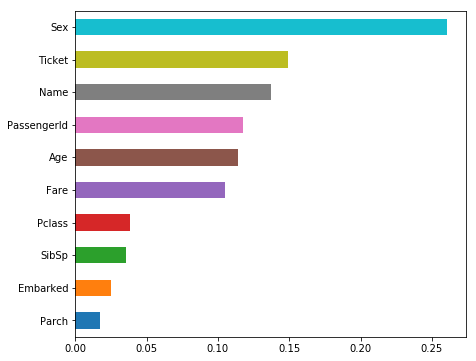

In [13]:
object_1.feature_importance(scaled_df)

### Building Baseline Model using Cross Validation and Grid Search

In [14]:
param_grid = [{'max_depth': [1,2,3,5,7,9]}, {'n_estimators': [10,25,50,100,250]}]

In [18]:
object_1.kfold_cross_val_with_param_grid(scaled_df, model = 'RandomForestClassifier', scoring='accuracy', parameter_grid=param_grid)

[CV]  ................................................................
[CV] .................................... , score=0.625, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7096774193548387, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7741935483870968, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7741935483870968, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7096774193548387, total=   0.0s
Baseline Model accuracy: 0.72 (0.05) Accuracy


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Best params: 10
Best max_depth: 5


### Build Final Model using the Best Model Parameters

In [16]:
object_1.final_model(scaled_df, model = 'RandomForestClassifier', best_params={'n_estimators': 10, 'max_depth': 5}, scoring='accuracy')

[CV]  ................................................................
[CV] .................................. , score=0.78125, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7741935483870968, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7419354838709677, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.7096774193548387, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8064516129032258, total=   0.0s
Model with best params, Results: 0.76 (0.03) Accuracy


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
